### increase ram size if required

In [ ]:
i = []
while True:
  i.append(i)

### mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)

2.4.1


### get list of top 40 features based on t-test

In [ ]:
t_statistic_array = np.abs(np.genfromtxt("/content/drive/MyDrive/Thesis/files/no_background/t_statistic_array.csv", delimiter=','))
ttest_df = pd.DataFrame(data=t_statistic_array, columns=['ttest_val'])
ttest_df.ttest_val = np.abs(ttest_df.ttest_val.values)
ttest_df.insert(loc=0, column='band_no', value=np.arange(186))

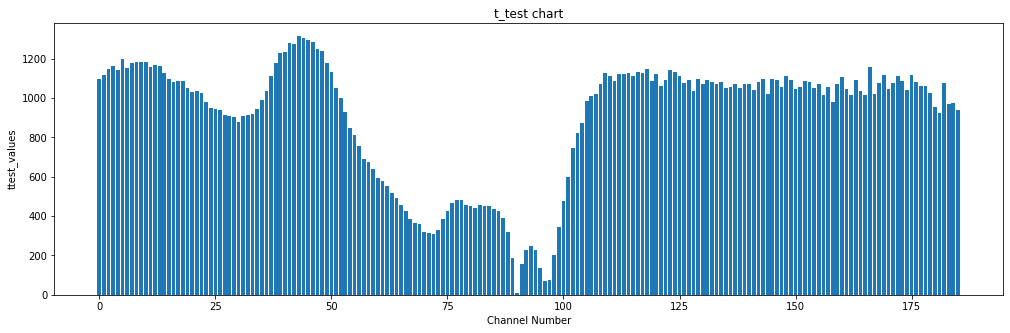

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(ttest_df.band_no.values, ttest_df.ttest_val.values)
plt.xlabel('Channel Number')
plt.ylabel('ttest_values')
plt.title('t_test chart')
# plt.savefig('/content/drive/MyDrive/Thesis/images/' + '.png')
plt.show() 

In [ ]:
bands_list = np.array([ 44,  45,  47,  46,  49,  48,  42,  43,  50,  51,  41,  40,  52, 
                       39,  53,  54,  56,  38,  55, 167, 119, 110, 124, 117, 115, 125, 176, 
                       173, 114, 113, 118, 111, 183, 170, 121, 161, 149, 126, 116, 57])

In [ ]:
top_selected = ttest_df[ttest_df.band_no.isin(bands_list)]

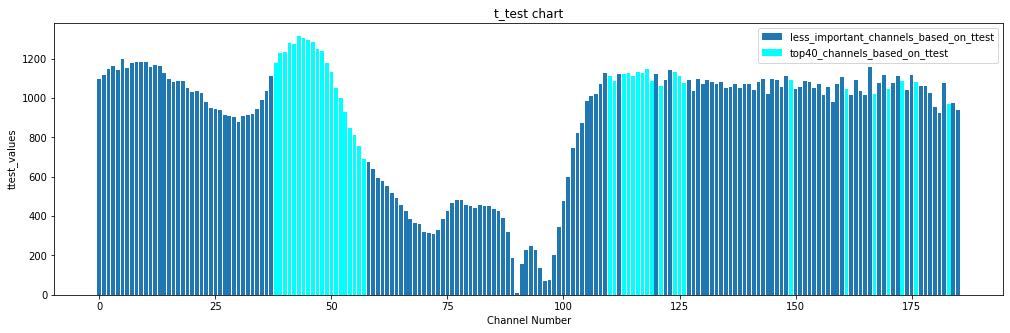

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(ttest_df.band_no.values, ttest_df.ttest_val.values, label='less_important_channels_based_on_ttest')
plt.bar(top_selected.band_no.values, top_selected.ttest_val.values, color='cyan', label='top40_channels_based_on_ttest')
plt.xlabel('Channel Number')
plt.ylabel('ttest_values')
plt.title('t_test chart')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/Thesis/images/normalized/no_background/LR/' + 'top40_ttest_normalized' + '.png')
plt.show() 

### load selected channels for training

In [ ]:
y = np.load('/content/drive/MyDrive/Thesis/segmented_bands/label.npy')

In [ ]:
y.shape

(8410045,)

In [ ]:
X = np.zeros((8410045, 40), dtype='float32')

In [ ]:
for i in range(len(bands_list)):
  X[:, i:i+1] = np.load('/content/drive/MyDrive/Thesis/segmented_bands/band_' + str(bands_list[i]) + '.npy').reshape(-1, 1)
  print(i)

In [ ]:
# using numpy =====================================
# X = np.concatenate((X, y), axis=1)
# np.random.shuffle(X)
# y = X[:, 50:]
# X = np.delete(X, 50, 1)

In [ ]:
df = pd.DataFrame(data=X)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.081628,0.082246,0.085431,0.082209,0.085600,0.083697,0.081314,0.080748,0.085764,0.087223,0.082994,0.080989,0.088558,0.081016,0.087292,0.090143,0.088575,0.074765,0.091832,0.276917,0.205657,0.194963,0.210896,0.198488,0.197381,0.210913,0.280577,0.297305,0.196735,0.195890,0.200913,0.19665,0.289494,0.296084,0.202966,0.276127,0.252226,0.211765,0.199281,0.092812
1,0.093623,0.097864,0.099247,0.098773,0.097506,0.100791,0.094340,0.094785,0.101604,0.101581,0.092296,0.091789,0.104166,0.082082,0.101183,0.102780,0.102613,0.084942,0.107643,0.341444,0.263656,0.255374,0.277620,0.264362,0.264889,0.280218,0.323957,0.333967,0.259298,0.256119,0.268123,0.25594,0.329328,0.329748,0.268474,0.334451,0.301649,0.272473,0.262482,0.103786
2,0.090981,0.092011,0.097458,0.093833,0.095819,0.094397,0.093519,0.092634,0.098819,0.097097,0.089847,0.092310,0.099581,0.089588,0.102386,0.102394,0.104574,0.087074,0.102893,0.302768,0.250737,0.242091,0.254455,0.245912,0.245833,0.259417,0.309852,0.318563,0.243044,0.240436,0.250791,0.24328,0.317119,0.323051,0.249026,0.313106,0.293755,0.259000,0.248540,0.105358


In [ ]:
df.insert(0, "label", value=np.array(y, dtype=int), allow_duplicates=True)

In [ ]:
df = df.sample(frac = 1)
df.head(3)

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
614765,1,0.083661,0.085998,0.086989,0.085603,0.088619,0.089258,0.083252,0.082653,0.089819,0.092242,0.079612,0.078673,0.090189,0.073675,0.093038,0.089614,0.090720,0.076790,0.087359,0.322449,0.334940,0.332749,0.338076,0.335019,0.331218,0.339575,0.308235,0.301759,0.333272,0.333660,0.338127,0.340254,0.301691,0.311515,0.339282,0.315584,0.330172,0.343667,0.340739,0.093668
5849720,1,0.113706,0.116625,0.119181,0.115890,0.115987,0.120399,0.108057,0.108099,0.114228,0.113667,0.105774,0.097404,0.108920,0.088651,0.105325,0.101457,0.097503,0.086656,0.098263,0.315898,0.334156,0.329587,0.329809,0.334727,0.332886,0.336584,0.306395,0.302681,0.341745,0.334702,0.343409,0.331148,0.292027,0.327466,0.343143,0.332000,0.328642,0.337564,0.339831,0.094165
5655192,1,0.153300,0.158559,0.163623,0.162250,0.168675,0.171299,0.152832,0.150708,0.169951,0.171474,0.148121,0.136992,0.163789,0.127860,0.164308,0.160894,0.161147,0.126123,0.158606,0.462902,0.453607,0.461355,0.460492,0.458644,0.456690,0.469117,0.435970,0.433912,0.464904,0.463929,0.465293,0.453317,0.426135,0.440061,0.456862,0.447371,0.451700,0.464191,0.459458,0.151971


### logistic regression using keras

In [ ]:
X = df.iloc[:, 1:]

In [ ]:
# np.save('/content/drive/MyDrive/Thesis/shuffled_top40/dataset.npy', X)

In [ ]:
y = df.iloc[:, 0:1]

In [ ]:
# np.save('/content/drive/MyDrive/Thesis/shuffled_top40/label.npy', y)

In [ ]:
# y = np.load('/content/drive/MyDrive/Thesis/shuffled_top40/label.npy')

In [ ]:
# X = np.load('/content/drive/MyDrive/Thesis/shuffled_top40/dataset.npy')

start preparing dataset

In [ ]:
input_shape = [X.shape[1],]
input_shape

[40]

In [ ]:
band_normalizer = preprocessing.Normalization(input_shape=input_shape)

In [ ]:
bands = np.array(X)

In [ ]:
band_normalizer.adapt(bands)

In [ ]:
model = tf.keras.Sequential([
    band_normalizer,
    layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 40)                81        
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 122
Trainable params: 41
Non-trainable params: 81
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=3)

In [ ]:
%%time
history = model.fit(
    X, y,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 25% of the training data
    validation_split = 0.25,
    callbacks=[callback]
    )

Epoch 1/100
197111/197111 [==============================] - 232s 1ms/step - loss: 0.4569 - accuracy: 0.8055 - val_loss: 0.5354 - val_accuracy: 0.7990
Epoch 2/100
197111/197111 [==============================] - 238s 1ms/step - loss: 0.4546 - accuracy: 0.8068 - val_loss: 0.4096 - val_accuracy: 0.8259
Epoch 3/100
197111/197111 [==============================] - 239s 1ms/step - loss: 0.4531 - accuracy: 0.8075 - val_loss: 0.4357 - val_accuracy: 0.8154
Epoch 4/100
197111/197111 [==============================] - 233s 1ms/step - loss: 0.4540 - accuracy: 0.8072 - val_loss: 0.4373 - val_accuracy: 0.8172
CPU times: user 19min 49s, sys: 2min 43s, total: 22min 32s
Wall time: 15min 44s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.454222,0.806868,0.535399,0.799022,0
1,0.454032,0.807217,0.409621,0.825887,1
2,0.453260,0.807368,0.435736,0.815433,2
3,0.454079,0.807038,0.437310,0.817162,3


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('error')
  plt.legend()
  plt.grid(True)

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

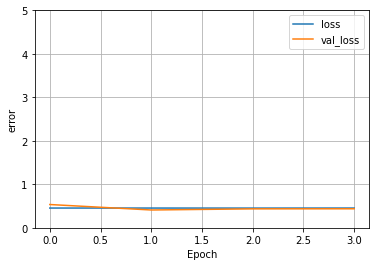

In [ ]:
plot_loss(history)

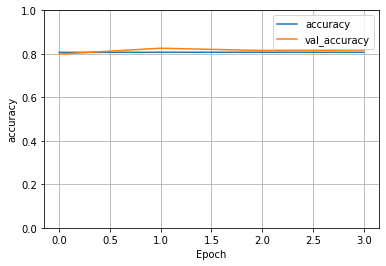

In [ ]:
plot_accuracy(history)

In [ ]:
# predict = model.predict(X)
# accuracy_score(np.round(predict), y[:])

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)